## Trabalho Prático 1

## A

i) Determine e mostre a resposta em frequência (amplitude e fase). Apresente o Diagrama-Polos-Zeros. Nota:
Resolva para conjunto de ganhos separadamente.


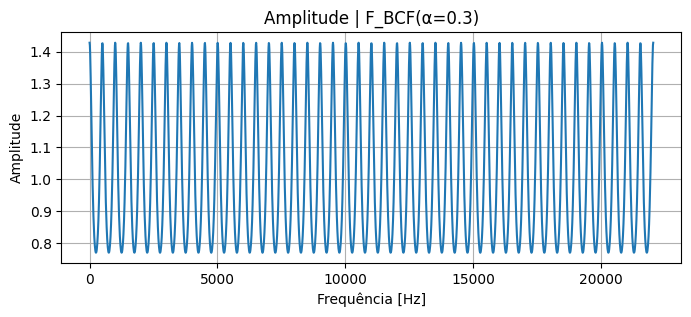

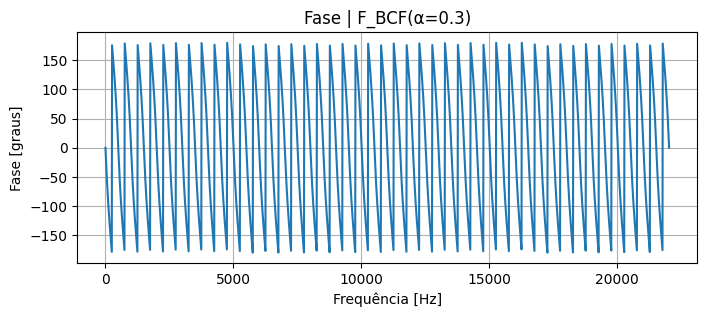

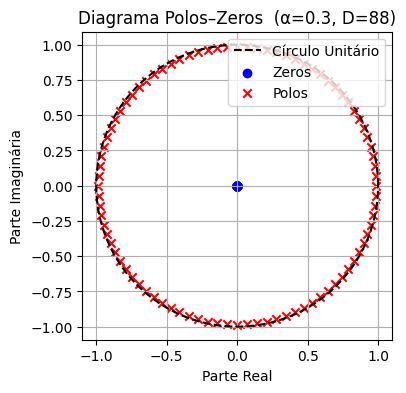

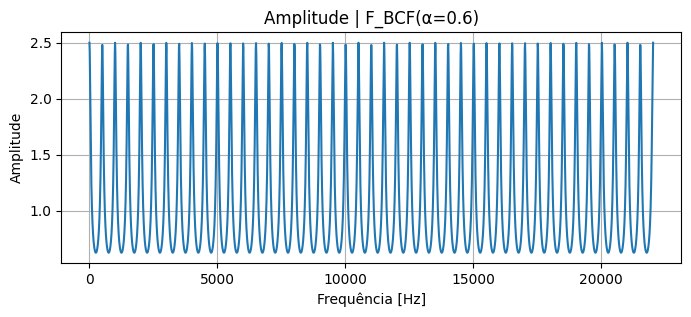

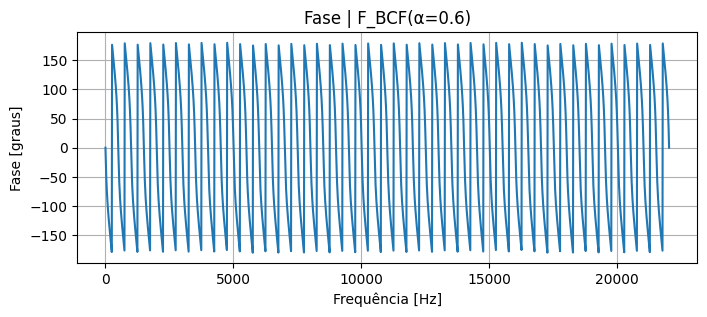

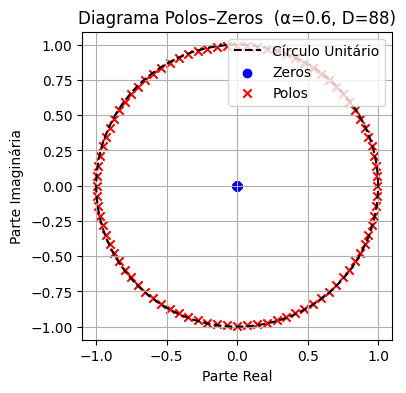

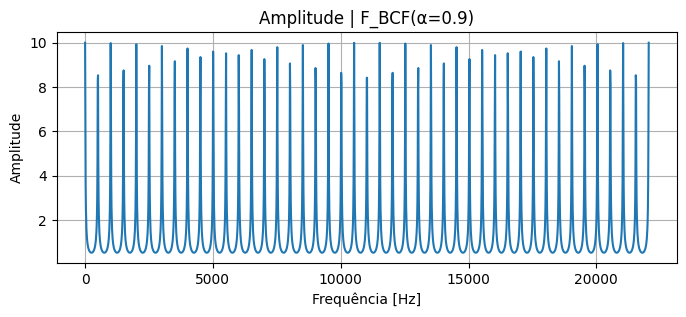

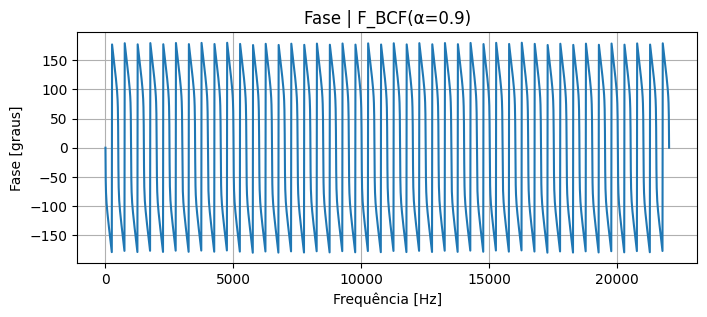

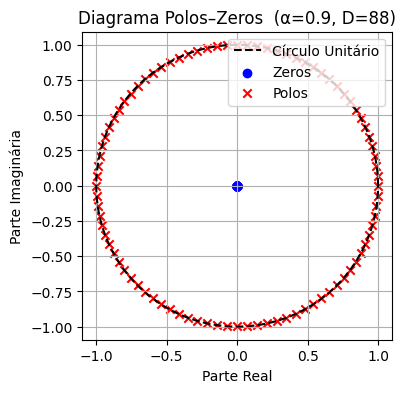

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Feedback Comb Filter
# F_BCF(α, D_c) = z^{-D_c} / (1 - α z^{-D_c})
# ==============================

# --- Parâmetros ---
fs = 44100          # frequência de amostragem [Hz]
delay_ms = 2       # atraso (milissegundos)
D = int(round(delay_ms * fs / 1000))  # atraso em amostras

# Conjunto de ganhos a analisar separadamente
alpha_list = [0.3, 0.6, 0.9]

# Grelha de frequências
N = 2048
w = np.linspace(0, np.pi, N)
f = w * fs / (2 * np.pi)

# --- Loop principal ---
for alpha in alpha_list:
    # Função de transferência no domínio da frequência
    ejwD = np.exp(-1j * w * D)
    H = ejwD / (1 - alpha * ejwD)

    # Resposta em amplitude e fase
    H_abs = np.abs(H)
    H_ang = np.angle(H) * 180 / np.pi

    # ---------- Gráfico de amplitude ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_abs)
    plt.title(f"Amplitude | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # ---------- Gráfico de fase ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_ang)
    plt.title(f"Fase | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Fase [graus]")
    plt.grid(True)
    plt.show()

    # ---------- Diagrama Polos–Zeros (inlined) ----------
    # Zeros: D zeros na origem
    z = np.zeros(D, dtype=complex)
    # Polos: soluções de z^D = α
    r = np.abs(alpha)**(1/D)
    angles = (np.angle(alpha) + 2*np.pi*np.arange(D)) / D
    p = r * np.exp(1j * angles)

    plt.figure(figsize=(4, 4))
    theta = np.linspace(0, 2*np.pi, 512)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo Unitário')
    plt.scatter(np.real(z), np.imag(z), marker='o', color='b', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='r', label='Polos')
    plt.axis('equal')
    plt.xlabel("Parte Real")
    plt.ylabel("Parte Imaginária")
    plt.title(f"Diagrama Polos–Zeros  (α={alpha}, D={D})")
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.xlim(0.995, 1.001)
    #plt.ylim(-0.005, 0.005)
    plt.show()


II)Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade.

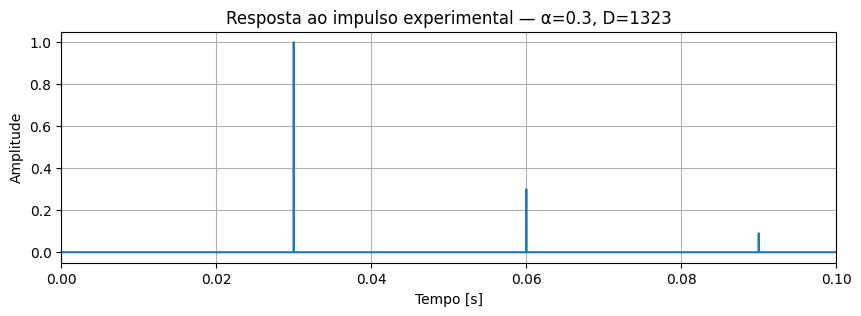

Guardado resposta ao impulso experimental em ex1_audio\impulse_FBCF_alpha0.3_D1323_fs44100.wav


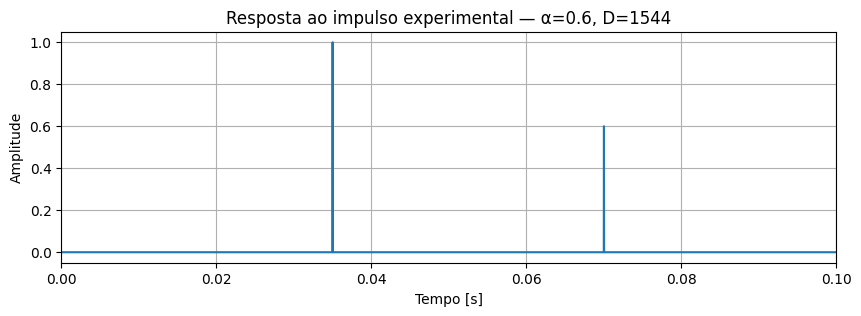

Guardado resposta ao impulso experimental em ex1_audio\impulse_FBCF_alpha0.6_D1544_fs44100.wav


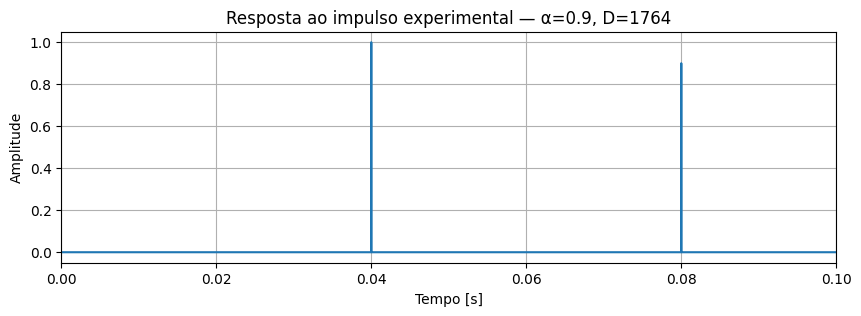

Guardado resposta ao impulso experimental em ex1_audio\impulse_FBCF_alpha0.9_D1764_fs44100.wav


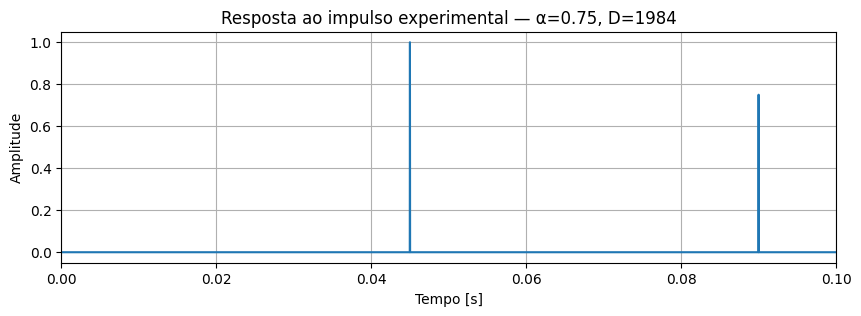

Guardado resposta ao impulso experimental em ex1_audio\impulse_FBCF_alpha0.75_D1984_fs44100.wav


Guardado resposta ao impulso do comb-bank em ex1_audio\impulse_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100.wav


Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import soundfile as sf
from IPython.display import Audio, display
import os

# ==============================
# Exercício II: Resposta ao impulso experimental
# - calcula resposta ao impulso aplicando um delta
# - plota a resposta
# - guarda como WAV
# - reproduz inline
# ==============================

fs = 44100
# Usar o mesmo conjunto de 4 combs do Exercício III para consistência
delays_ms = [30, 35, 40, 45]
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
alphas = [0.3, 0.6, 0.9, 0.75]

folder = "ex1_audio"
# comprimento do delta/resposta (vê-se decaimento) — usa maior D para garantir cobertura
if max(D_list) > 0:
    L = 8 * max(D_list)
else:
    L = 1024

delta = np.zeros(L, dtype=np.float32)
delta[0] = 1.0

# Calcular e guardar respostas impulsionais individuais e a resposta somada (combbank)
h_combbank = np.zeros(L, dtype=np.float32)
for alpha, D in zip(alphas, D_list):
    # Inlined apply_fbcf_impulse logic
    b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
    a = np.hstack([[1.0], np.zeros(D-1), [-alpha]]).astype(np.float32)
    h_exp = lfilter(b, a, delta)

    # Plot - resposta ao impulso no domínio do tempo
    t = np.arange(len(h_exp)) / fs
    plt.figure(figsize=(10,3))
    plt.plot(t, h_exp)
    plt.title(f"Resposta ao impulso experimental — α={alpha}, D={D}")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xlim(0, min(0.1, t[-1]))  # mostra os primeiros 100 ms por defeito
    plt.show()

    # Guardar como WAV (normalizado para evitar clipping)
    h_save = h_exp / (np.max(np.abs(h_exp)) + 1e-12)
    fname = f"impulse_FBCF_alpha{alpha}_D{D}_fs{fs}.wav"
    fpath = os.path.join(folder, fname)  # <-- junta o caminho da pasta
    sf.write(fpath, h_save.astype(np.float32), fs)
    print('Guardado resposta ao impulso experimental em', fpath)

    # Reproduzir inline (nota: reprodução funciona no Jupyter)
    display(Audio(h_save, rate=fs))

    # acumular na resposta do banco
    h_combbank[:len(h_exp)] += h_exp

# Normalizar e guardar a resposta impulsional do comb-bank (soma dos 4 combs)
hh_cb_save = h_combbank / (np.max(np.abs(h_combbank)) + 1e-12)
fname_cb = f"impulse_FBCF_combbank_alphas{'-'.join(str(a).replace('.', 'p') for a in alphas)}_delays{'-'.join(str(d) for d in delays_ms)}_fs{fs}.wav"
fpath_cb = os.path.join(folder, fname_cb)  # <-- junta o caminho da pasta
sf.write(fpath_cb, hh_cb_save.astype(np.float32), fs)
print('Guardado resposta ao impulso do comb-bank em', fpath_cb)
display(Audio(hh_cb_save, rate=fs))

print('Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.')


III)Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade

Neste bloco geramos a resposta ao impulso (entrada delta), comparamos com a resposta teórica, guardamos o impulso como WAV e aplicamos o filtro a sinais de teste: seno, chirp e ruído branco.

In [ ]:
import numpy as np
from scipy.signal import lfilter
from scipy.signal import chirp
import soundfile as sf
import os

folder = "ex1_audio"
fs = 44100
delays_ms = [30, 35, 40, 45]
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
alphas = [0.3, 0.6, 0.9, 0.75]

dur = 2.0
N = int(dur * fs)
t = np.arange(N) / fs

sine = 0.6 * np.sin(2*np.pi*1000*t).astype(np.float32)
chirp_sig = 0.6 * chirp(t, f0=100, f1=6000, t1=dur, method='linear').astype(np.float32)
noise = 0.3 * np.random.randn(N).astype(np.float32)

alphas_tag = "-".join(str(a).replace('.', 'p') for a in alphas)
delays_tag = "-".join(str(d) for d in delays_ms)

# Processar sinais de teste: gravar ficheiro WET-ONLY estéreo (L=wet, R=wet)
for name, sig in [('sine1k', sine), ('chirp', chirp_sig), ('noise', noise)]:
    wet = np.zeros_like(sig, dtype=np.float32)
    for alpha_val, D in zip(alphas, D_list):
        b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
        a_coef = np.hstack([[1.0], np.zeros(D-1), [-alpha_val]]).astype(np.float32)
        wet += lfilter(b, a_coef, sig)

    # Normalizar só o wet
    max_abs = np.max(np.abs(wet))
    if max_abs > 0:
        wet = wet / (max_abs + 1e-12)

    wet_stereo = np.stack([wet, wet], axis=1)
    # Normalização final de segurança
    wet_stereo = wet_stereo / (np.max(np.abs(wet_stereo)) + 1e-12)

    outname = f"{name}_FBCF_combbank_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    outpath = os.path.join(folder, outname)  # <-- juntar pasta + nome
    sf.write(outpath, wet_stereo.astype(np.float32), fs)
    print("Guardado:", outpath)

try:
    audio, sf_fs = sf.read('audio.wav', always_2d=True)
    if sf_fs != fs:
        print(f'AVISO: audio.wav tem taxa {sf_fs}Hz diferente de {fs}Hz — será processado sem resample.')
    audio_mono = np.mean(audio, axis=1).astype(np.float32)

    wet_audio = np.zeros_like(audio_mono, dtype=np.float32)
    for alpha_val, D in zip(alphas, D_list):
        b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
        a_coef = np.hstack([[1.0], np.zeros(D-1), [-alpha_val]]).astype(np.float32)
        wet_audio += lfilter(b, a_coef, audio_mono)

    # Normaliza só o wet
    max_abs = np.max(np.abs(wet_audio))
    if max_abs > 0:
        wet_audio = wet_audio / (max_abs + 1e-12)

    wet_audio_st = np.stack([wet_audio, wet_audio], axis=1)
    wet_audio_st = wet_audio_st / (np.max(np.abs(wet_audio_st)) + 1e-12)

    out_audio = f"audio_FBCF_combbank_WETONLY_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    out_audio_path = os.path.join(folder, out_audio)  # <-- juntar pasta + nome
    sf.write(out_audio_path, wet_audio_st.astype(np.float32), fs)
    print("Guardado:", out_audio_path)

except Exception as e:
    print('audio.wav não encontrado ou não pôde ser lido; ficheiro ignorado. (Detalhe:', e, ')')

print('Exercício III concluído: Gerado para sinais e (se existir) audio.wav.')


Guardado: C:\Users\helen\OneDrive\Documents\GitHub\Semestre3\PSM\TP1\ex1_audio\sine1k_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Guardado: C:\Users\helen\OneDrive\Documents\GitHub\Semestre3\PSM\TP1\ex1_audio\chirp_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Guardado: C:\Users\helen\OneDrive\Documents\GitHub\Semestre3\PSM\TP1\ex1_audio\noise_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Guardado: C:\Users\helen\OneDrive\Documents\GitHub\Semestre3\PSM\TP1\ex1_audio\audio_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Exercício III concluído: WET-ONLY gerado para sinais e (se existir) audio.wav.




## B

i) Determinar e mostrar a resposta em frequência (amplitude e fase) e apresentar o diagrama polos-zeros.
Resolver para um conjunto de ganhos separadamente (cada ganho em figura própria).

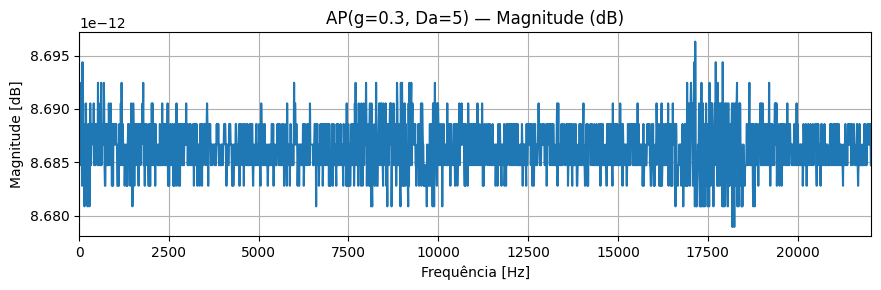

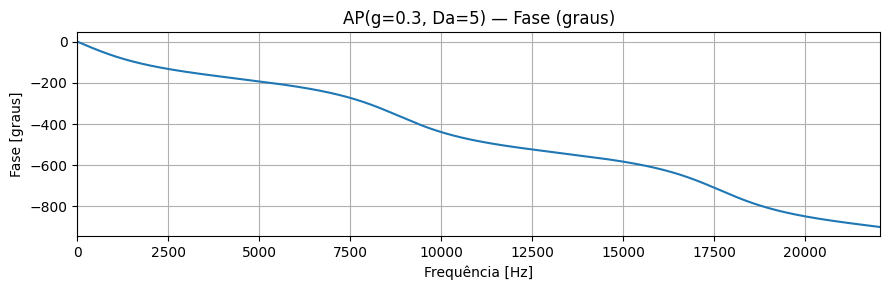

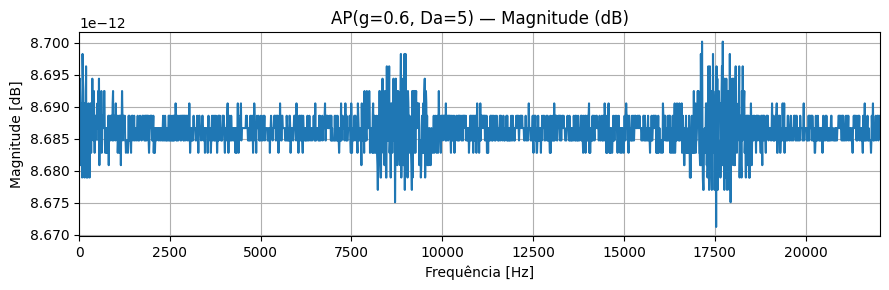

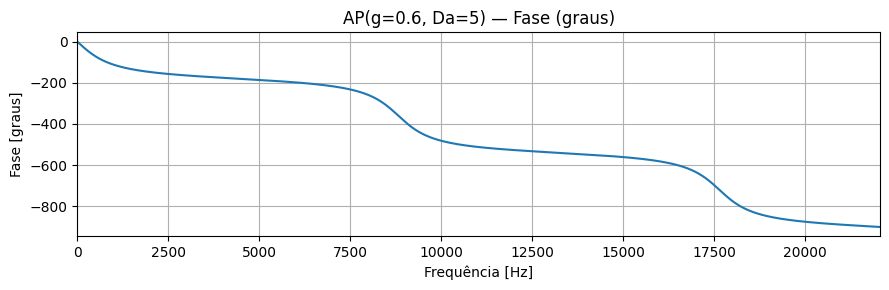

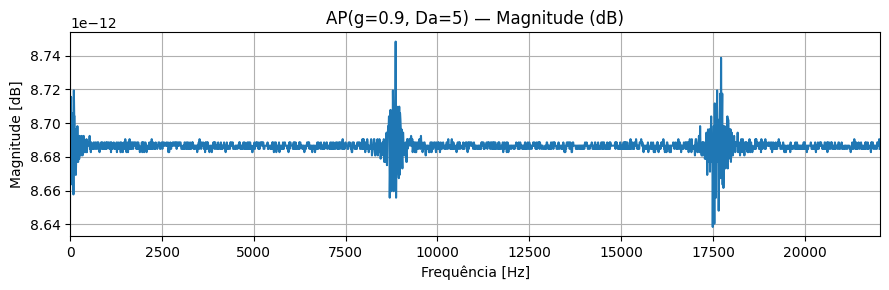

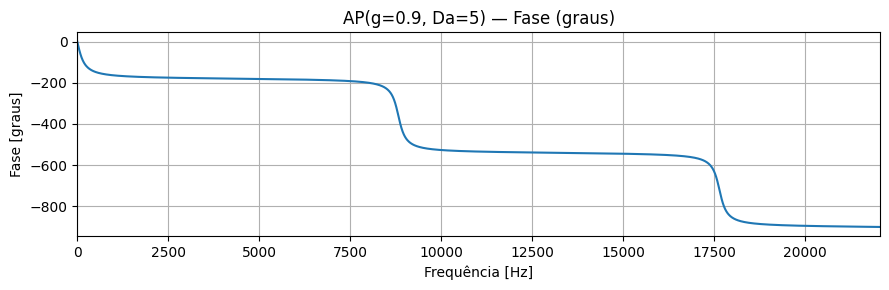

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz


fs = 44100  # taxa de amostragem (Hz)
Da = 5      # atraso em amostras (pode alterar conforme pedido)
gains = [0.3, 0.6, 0.9]  # conjunto de ganhos a analisar separadamente

for g in gains:
    b = np.zeros(Da+1)
    a = np.zeros(Da+1)
    b[0] = -g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -g

    w, H = freqz(b, a, worN=2048)
    f = w * fs / (2 * np.pi) # converter para Hz

    # Magnitude (dB) e fase (graus, unwrap para suavizar)
    plt.figure(figsize=(9, 3))
    plt.plot(f, 20*np.log10(np.abs(H) + 1e-12)) # converte a magnitude para dB e usei 1e-12 para evitar log(0)
    plt.title(f'AP(g={g}, Da={Da}) — Magnitude (dB)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 3))
    plt.plot(f, np.unwrap(np.angle(H)) * 180/np.pi) # converte a fase para graus e unwrap para suavizar
    plt.title(f'AP(g={g}, Da={Da}) — Fase (graus)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Fase [graus]')
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()


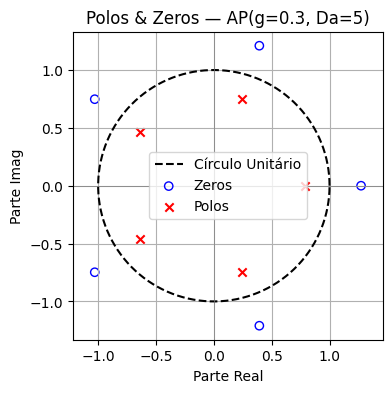

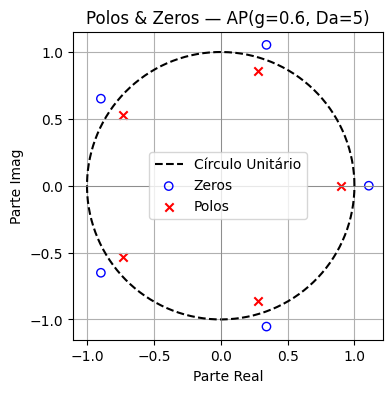

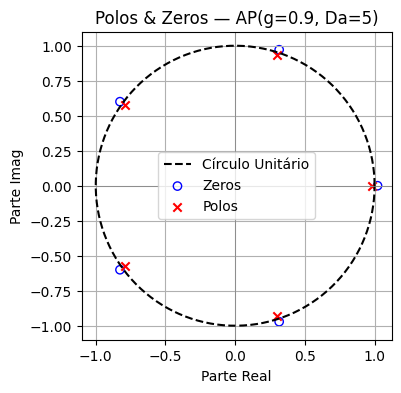

In [ ]:
# Diagrama polos-zeros (polinómios em z para np.roots)
import numpy as np
import matplotlib.pyplot as plt

for g in gains:
    num_z = np.zeros(Da+1, dtype=float)
    den_z = np.zeros(Da+1, dtype=float)
    num_z[0] = -g    # coeficiente de z^Da
    num_z[-1] = 1.0 # termo independente
    den_z[0] = 1.0  # coeficiente de z^Da
    den_z[-1] = -g  # termo independente

    zeros = np.roots(num_z)
    poles = np.roots(den_z)

    plt.figure(figsize=(4,4))
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo Unitário')
    if zeros.size > 0: #Se a lista de zeros não estiver vazia, desenha-os
        plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='b', label='Zeros')
    if poles.size > 0:
        plt.scatter(np.real(poles), np.imag(poles), marker='x', color='r', label='Polos')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.legend()
    plt.title(f'Polos & Zeros — AP(g={g}, Da={Da})')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imag')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


 II) Determine experimentalmente a resposta impulsional. Ilustre graficamente, guarde num ficheiro wave e
escute o resultado.


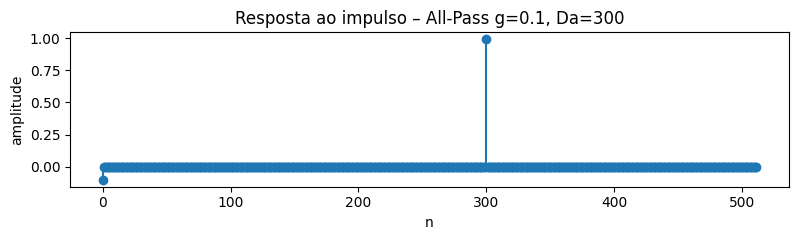

Guardado: impulse_AP_g0p1_Da300.wav


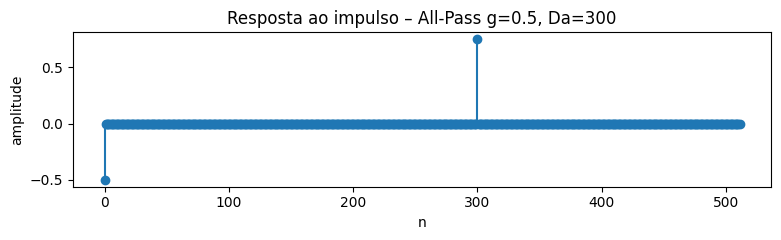

Guardado: impulse_AP_g0p5_Da300.wav


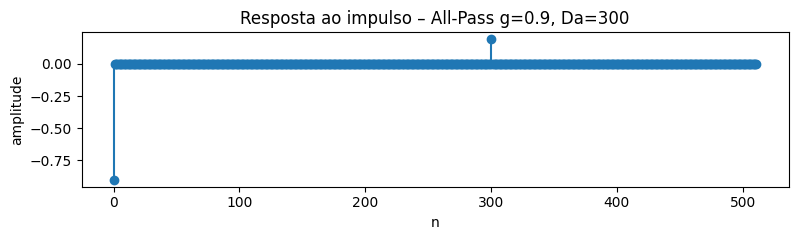

Guardado: impulse_AP_g0p9_Da300.wav


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display
import os

fs = 44100
N_imp = 512
gains = [0.1, 0.5, 0.9]
Da = 300  # atraso em amostras

for g in gains:
    # AP(g, Da) = (-g + z^-Da) / (1 - g z^-Da)
    b = np.zeros(Da + 1)
    a = np.zeros(Da + 1)
    b[0] = -g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -g

    # impulso
    x = np.zeros(N_imp)
    x[0] = 1.0

    # resposta impulsional experimental
    y_imp = signal.lfilter(b, a, x)

    # mostra gráfico
    plt.figure(figsize=(8, 2.5))
    plt.stem(np.arange(len(y_imp)), y_imp, basefmt=" ")
    plt.title(f"Resposta ao impulso – All-Pass g={g}, Da={Da}")
    plt.xlabel("n"); plt.ylabel("amplitude")
    plt.tight_layout()
    plt.show()

    # normalizar e guardar
    y_imp_norm = 0.9 * y_imp / np.max(np.abs(y_imp))
    folder = "ex2_audio"
    fname = f"impulse_AP_g{str(g).replace('.','p')}_Da{Da}.wav"
    sf.write(os.path.join(folder, fname), y_imp_norm.astype(np.float32), fs)
    print("Guardado:", fname)

    # tocar no notebook
    display(Audio(y_imp_norm, rate=fs))


iii) Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade

In [ ]:
import numpy as np
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display
import os

# ============================
# PARÂMETROS DO ALL-PASS
# AP(g, Da) = (-g + z^-Da) / (1 - g z^-Da)
# ============================
g = 0.65      # ganho (0 < g < 1). Mais perto de 1 = efeito mais forte
Da = 350      # atraso em amostras (~8 ms a 44.1 kHz)

# construir coeficientes
b = np.zeros(Da + 1)
a = np.zeros(Da + 1)
b[0] = -g
b[-1] = 1.0
a[0] = 1.0
a[-1] = -g


x, fs = sf.read("voz.wav")    
if x.ndim > 1:
    x = x.mean(axis=1)         # stereo -> mono


y = signal.lfilter(b, a, x)

# opcional mas MUITO útil: misturar original + filtrado
dry = 0.35   # % da voz original
wet = 0.65   # % da voz com all-pass
y_mix = dry * x + wet * y

# normalizar p/ não saturar
y_mix = 0.9 * y_mix / (np.max(np.abs(y_mix)) + 1e-9)

folder = "ex2_audio"
sf.write(os.path.join(folder, "voz_allpass.wav"), y_mix.astype(np.float32), fs)
print("Guardado: voz_allpass.wav")

display(Audio(y_mix, rate=fs))


Guardado: voz_allpass.wav


## C

i) Determine e mostre a resposta em frequência (amplitude e fase).

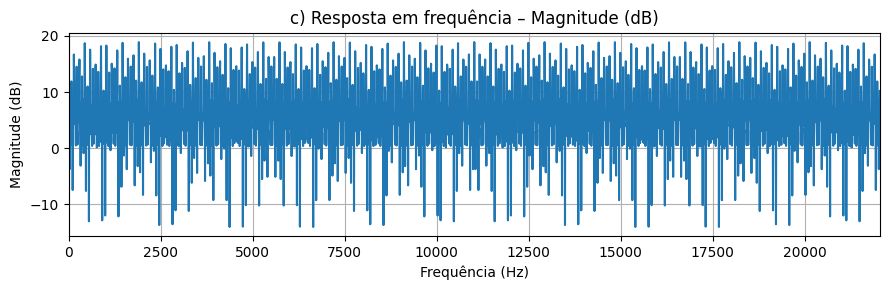

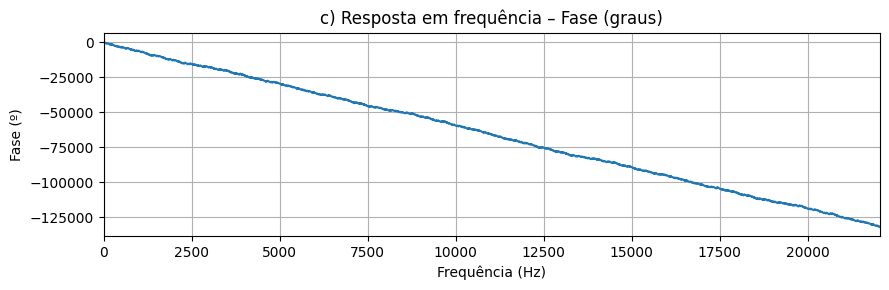

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def feedback_comb(alpha, Dc):
    """
    Feedback Comb Filter:
    H(z) = z^{-Dc} / (1 - alpha z^{-Dc})
    """
    b = np.zeros(Dc + 1)
    a = np.zeros(Dc + 1)
    b[-1] = 1.0          # z^{-Dc}
    a[0] = 1.0
    a[-1] = -alpha       # 1 - alpha z^{-Dc}
    return b, a

def allpass(g, Da):
    """
    All-Pass segundo o enunciado:
    AP(g, Da) = (-g + z^{-Da}) / (1 - g z^{-Da})
    """
    b = np.zeros(Da + 1)
    a = np.zeros(Da + 1)
    b[0] = -g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -g
    return b, a

def parallel_filters(filters):
    """
    Soma de filtros IIR: H = H1 + H2 + ...
    filters: lista de (b, a)
    devolve (B, A)
    """
    B = np.array([0.0])
    A = np.array([1.0])
    for (b, a) in filters:
        # H = B/A,  h = b/a  ->  H+h = (B a + b A)/(A a)
        B = np.polyadd(np.convolve(B, a), np.convolve(b, A))
        A = np.convolve(A, a)
    return B, A

def series_filters(filters):
    """
    Cascata de filtros: H = H1 * H2 * ...
    filters: lista de (b, a)
    devolve (B, A)
    """
    B = np.array([1.0])
    A = np.array([1.0])
    for (b, a) in filters:
        B = np.convolve(B, b)
        A = np.convolve(A, a)
    return B, A


fs = 44100  # só para escalar eixo da frequência

# Comb-filters (α, Dc)  -> põe aqui os que quiseres
comb_params = [
    (0.72, 1200),   # ~27 ms
    (0.65, 1500),   # ~34 ms
    (0.58, 1800),   # ~41 ms
]

comb_filters = [feedback_comb(alpha, Dc) for (alpha, Dc) in comb_params]
B_comb, A_comb = parallel_filters(comb_filters)

# All-pass em série depois dos combs
ap_params = [
    (0.7, 400),
    (0.6, 100),
]
ap_filters = [allpass(g, Da) for (g, Da) in ap_params]

# Estrutura final: (paralelo de combs) -> (all-pass 1) -> (all-pass 2)
B_tot, A_tot = series_filters([(B_comb, A_comb)] + ap_filters)


w, H = signal.freqz(B_tot, A_tot, worN=4096, fs=fs)

plt.figure(figsize=(9, 3))
plt.plot(w, 20*np.log10(np.abs(H) + 1e-12))
plt.title("c) Resposta em frequência – Magnitude (dB)")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.xlim(0, fs/2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
plt.plot(w, np.unwrap(np.angle(H)) * 180/np.pi)
plt.title("c) Resposta em frequência – Fase (graus)")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Fase (º)")
plt.grid(True)
plt.xlim(0, fs/2)
plt.tight_layout()
plt.show()

# zeros = raízes do numerador, polos = raízes do denominador
zeros = np.roots(B_tot)
poles = np.roots(A_tot)

plt.figure(figsize=(4, 4))
# círculo unitário
theta = np.linspace(0, 2*np.pi, 400)
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)

# zeros (o) e polos (x)
plt.plot(np.real(zeros), np.imag(zeros), 'o', label='Zeros')
plt.plot(np.real(poles), np.imag(poles), 'x', label='Polos')

plt.title("c) Diagrama Polos–Zeros (sistema combinado)")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


ii)Determine experimentalmente a resposta impulsional. Ilustre graficamente, guarde num ficheiro wave e
escute o resultado.

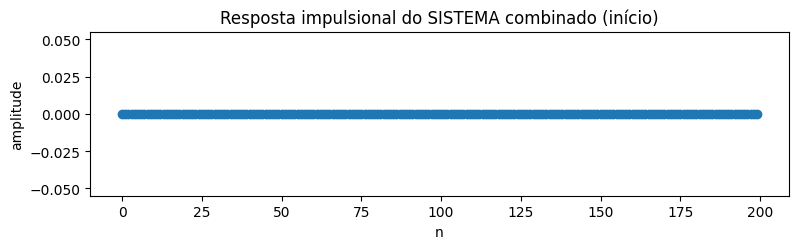

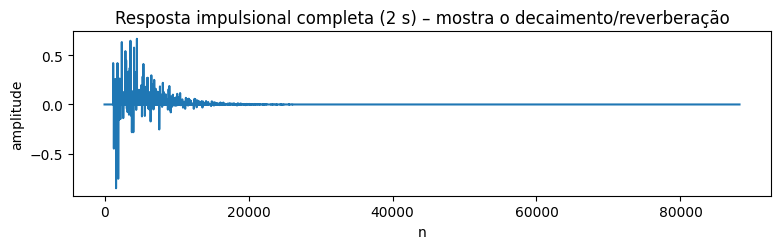

Guardado: response_system_iiC.wav


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display
import os

def feedback_comb(alpha, Dc):
    # FBCF(α, Dc) = z^{-Dc} / (1 - α z^{-Dc})
    b = np.zeros(Dc + 1)
    a = np.zeros(Dc + 1)
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -alpha
    return b, a

def allpass(g, Da):
    # AP(g, Da) = (-g + z^{-Da}) / (1 - g z^{-Da})
    b = np.zeros(Da + 1)
    a = np.zeros(Da + 1)
    b[0] = -g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -g
    return b, a

def parallel_filters(filters):
    B = np.array([0.0])
    A = np.array([1.0])
    for (b, a) in filters:
        B = np.polyadd(np.convolve(B, a), np.convolve(b, A))
        A = np.convolve(A, a)
    return B, A

def series_filters(filters):
    B = np.array([1.0])
    A = np.array([1.0])
    for (b, a) in filters:
        B = np.convolve(B, b)
        A = np.convolve(A, a)
    return B, A



fs = 44100

# combs em paralelo
comb_params = [
    (0.72, 1200),   # α, Dc
    (0.65, 1500),
    (0.58, 1800),
]
comb_filters = [feedback_comb(alpha, Dc) for (alpha, Dc) in comb_params]
B_comb, A_comb = parallel_filters(comb_filters)

# all-pass em série depois dos combs
ap_params = [
    (0.7, 400),
    (0.6, 100),
]
ap_filters = [allpass(g, Da) for (g, Da) in ap_params]

# sistema TOTAL: (combs) -> (ap1) -> (ap2)
B_tot, A_tot = series_filters([(B_comb, A_comb)] + ap_filters)



# vamos pôr 2 segundos de duração para se ouvir o decaimento
dur = 2.0
N_imp = int(dur * fs)

# impulso δ[n]
x = np.zeros(N_imp, dtype=float)
x[0] = 1.0

# filtrar pelo sistema completo
h = signal.lfilter(B_tot, A_tot, x)



plt.figure(figsize=(8, 2.6))
plt.stem(np.arange(200), h[:200], basefmt=" ")
plt.title("Resposta impulsional do SISTEMA combinado (início)")
plt.xlabel("n"); plt.ylabel("amplitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2.6))
plt.plot(h)
plt.title("Resposta impulsional completa (2 s) – mostra o decaimento/reverberação")
plt.xlabel("n"); plt.ylabel("amplitude")
plt.tight_layout()
plt.show()

# normalizar para não saturar
h_norm = 0.9 * h / np.max(np.abs(h))
folder = "ex3_audio"
fname = "response_system_iiC.wav"
sf.write(os.path.join(folder, fname), h_norm.astype(np.float32), fs)
print("Guardado:", fname)

# player no notebook
display(Audio(h_norm, rate=fs))


iii)Aplique este filtro a sinais de teste e sinais audio para testar a sua funcionalidade.

In [ ]:
import numpy as np
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display

# =========================
# 1. PARÂMETROS DO TEU FILTRO
# =========================
fs = 44100      # assume 44.1 kHz; se o teu wav tiver outro, já vemos
alpha = 0.7     # comb mais forte -> mais eco
Dc = 1700       # ~38 ms -> dá para ouvir
g = 0.6         # all-pass moderado
Da = 300        # ~6-7 ms
dry = 0.4       # % do som original
wet = 0.6       # % do som filtrado (wet > dry para se notar)

# =========================
# 2. CONSTRUIR OS 2 FILTROS
# =========================
# Comb: H(z) = z^-Dc / (1 - alpha z^-Dc)
b_comb = np.zeros(Dc + 1); b_comb[-1] = 1.0
a_comb = np.zeros(Dc + 1); a_comb[0] = 1.0; a_comb[-1] = -alpha

# All-pass: AP(g, Da) = (-g + z^-Da) / (1 - g z^-Da)
b_ap = np.zeros(Da + 1); b_ap[0] = -g; b_ap[-1] = 1.0
a_ap = np.zeros(Da + 1); a_ap[0] = 1.0; a_ap[-1] = -g

# =========================
# 3. LER O TEU ÁUDIO
# =========================
try:
    x, fs_file = sf.read("voz.wav")   # mete aqui o nome do teu ficheiro
    if x.ndim > 1:
        x = x.mean(axis=1)  # stereo -> mono

    # se o wav não for 44.1k, vamos usar o sample rate dele
    fs = fs_file

    # =========================
    # 4. APLICAR COMB -> ALL-PASS
    # =========================
    y = signal.lfilter(b_comb, a_comb, x)   # comb primeiro
    y = signal.lfilter(b_ap, a_ap, y)       # depois all-pass

    # =========================
    # 5. MISTURAR (dry/wet)
    # =========================
    # isto garante que o som filtrado se OUVE
    y_mix = dry * x + wet * y

    # normalizar
    y_mix = 0.9 * y_mix / (np.max(np.abs(y_mix)) + 1e-9)

    # =========================
    # 6. GUARDAR E OUVIR
    # =========================
    outname = "voz_proc.wav"
    folder = "ex3_audio"
    sf.write(os.path.join(folder, outname), y_mix.astype(np.float32), fs)
    print("Guardado:", outname)
    display(Audio(y_mix, rate=fs))

except FileNotFoundError:
    print("⚠️ Não encontrei 'voz.wav'. Mete o ficheiro na mesma pasta do notebook/script.")


Guardado: voz_proc.wav
